# Twitter Sentiment Analysis - AIR Project

**1. Importing libraries and installing tweepy**

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Flatten, SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from wordcloud import WordCloud
import time
import itertools
import re
import seaborn as sns

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install tweepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [3]:
import tweepy

In [4]:
#twitter API credentials
consumerKey = "V0AbktVHuciimTCOXSgU7Zbfc"
consumerSecret = "mREamg9BsZoJsIZNwDORE50GS7ZqWM9uAz5roornoIxj46xCgR"
accessToken = "1190269761948663809-ucGSjbsNsAaWerbXotnidWkEaxdc3M"
accessTokenSecret = "1vRd2O2IlGxeLc9BEc2zrimB8q0yCukFUHq7Mx5zSRbiG"

#create authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)
#Set access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)
#Create the API object while passing in the auth info
api = tweepy.API(authenticate)

#extract 10 tweets
posts = api.user_timeline(screen_name = "BillGates", count = 10, lang = "en", tweet_mode="extended")
for tweet in posts:
    print(tweet.full_text + '\n')

I am in awe of people who have dedicated their lives to making the world a more equitable place, and I feel lucky to be able to support their efforts. https://t.co/It4s0WRzH5

You don’t need to be a big soccer fan to recognize why it’s called “the beautiful game.” https://t.co/Bkiar7eYUu

RT @gatesfoundation: This is a major milestone in the fight against #malaria. Now, millions more people have access to a powerful new tool…

RT @AP: The major advance in fusion research announced on  Tuesday was decades in coming, with scientists for the first time able to engine…

In order to solve our world’s sanitation crisis, we need smarter toilets that don’t rely on sewage systems and prevent the spread of diseases. #WorldToiletDay https://t.co/gbp9F0GxlE

Collaboration and more open access to data have made seemingly impossible health breakthroughs a reality, like COVID-19 vaccines. @AlzData is putting the power of data behind one of our most critical health challenges. https://t.co/Qtatf2WMds


**2. Loading Data**

In [5]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin', header = None)
df.columns = ['sentiment', 'ID', 'date', 'query', 'username', 'tweet']
df.head(10)

,sentiment,ID,date,query,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


Only keep the columns needed for sentiment analysis and change sentiment to positive or negative.

In [6]:
data = df.drop(['ID', 'date', 'query', 'username'], axis = 1)
sent = { 0: 'Negative', 4: 'Positive'}
def label_decoder(label):
    return sent[label]

data.sentiment = data.sentiment.apply(lambda x : label_decoder(x))
data.head()

,sentiment,tweet
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Negative    800000
Positive    800000
Name: sentiment, dtype: int64


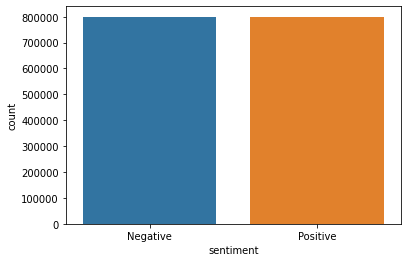

In [7]:
plt.figure()
sns.countplot(data['sentiment'])
print(data['sentiment'].value_counts())

**3. Preprocessing**

In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

def preprocess(text, stem = False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    text = re.sub(r'<3', '<heart>', text)
    text = re.sub(r"[8:=;]['`\-]?[)d]+", '<smile>', text)
    text = re.sub(r"[8:=;]['`\-]?\(+", '<sadface>', text)
    text = re.sub(r"[8:=;]['`\-]?[\/|l*]", '<neutralface>', text)
    text = re.sub(r"[8:=;]['`\-]?p+", '<lolface>', text)
    text = re.sub("[^a-z0-9<>]", ' ', text)
    tokens =[]
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

Test a tweet to see the difference before and after preprocessing

In [9]:
data.tweet[24821]

"I say &quot;I've got a 16GB flashdrive&quot;. He says &quot;I *saw* a 64GB flashdrive&quot;. Somehow his statement trumps mine. "

In [10]:
preprocess(data.tweet[24821], True)

'say quot got 16gb flashdriv quot say quot saw 64gb flashdriv quot somehow statement trump mine'

Apply preprocessing to all the data

In [11]:
data.tweet = data.tweet.apply(lambda x : preprocess(x))
data.head()

,sentiment,tweet
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


In [12]:
processedtext = list(data.tweet)
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

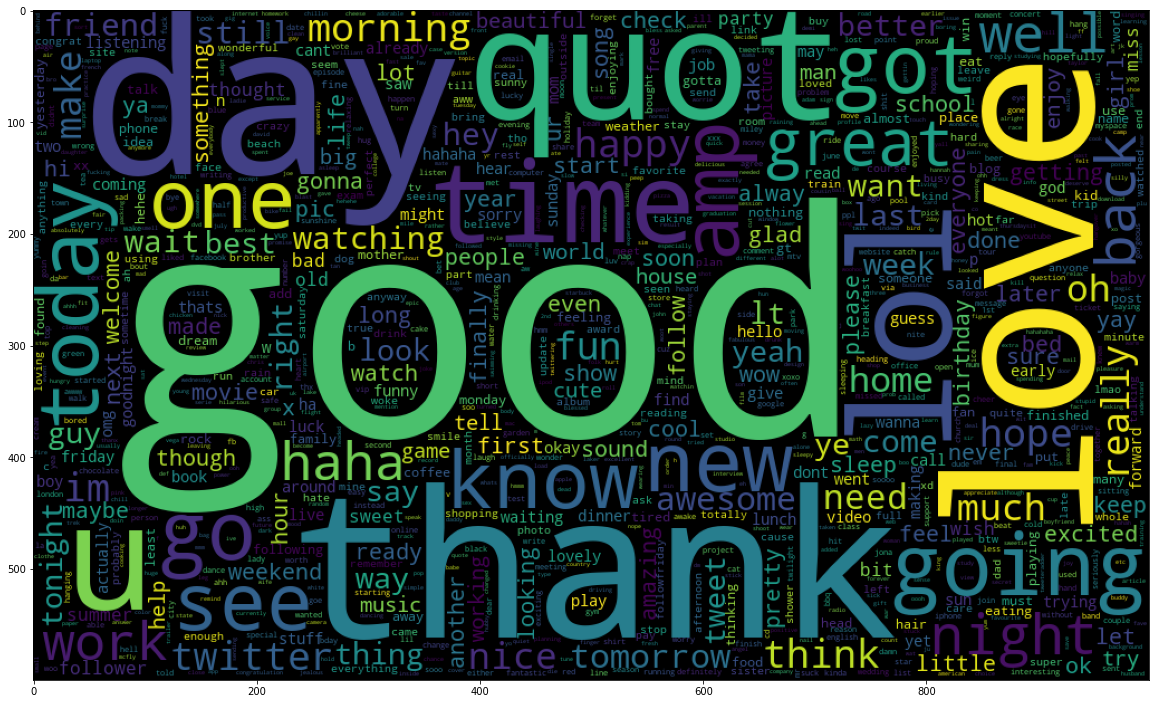

In [13]:
word_cloud = WordCloud(max_words = 1000 , width = 1000 , height = 600,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(word_cloud)

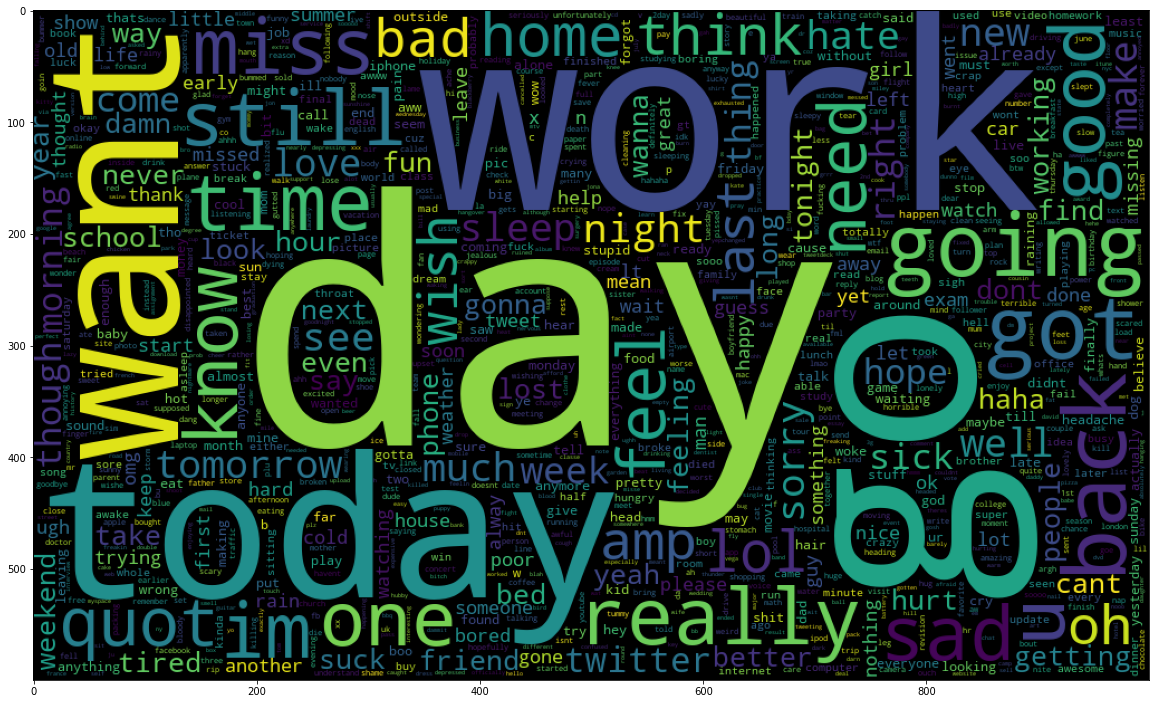

In [14]:
wc = WordCloud(max_words = 1000 , width = 1000 , height = 600,
              collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

Pull data about specific topics to and see how many tweets are positive versus negative about this topic

In [15]:
data = shuffle(data)
searchWords = '|'.join(['sport', 'player', 'game', 'ball', 'score', 'winner'])
filtered = data[data['tweet'].str.contains(searchWords, case=False)]
pd.set_option('display.max_colwidth', 0)
print("Amount of positive tweets:", filtered['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered['sentiment'].value_counts()['Negative'])
filtered.head(10)

Amount of positive tweets: 11747
Amount of negative tweets: 12274


,sentiment,tweet
518799,Negative,sadly think n64 broken tried hook brother read games blank screen
226180,Negative,havent gottten see talk boyfriend two days im liking summerball thing
1320414,Positive,play jv drinking game take drink every time says come another points
886764,Positive,kind sweets looking forward tweetage girlie bob twinners 3 btw
1394936,Positive,summer ball amazing however feeling like death sitting bed cuppa watching office
274981,Negative,vball camp omg stomach hurts
969092,Positive,guys friendly helping new players much guys rp im looking get rping
946530,Positive,chatted markham mayor frank scarpitti tonight ball asked post pic blog could check
774500,Negative,gonna watch bones instead watched game recordins africanbarbie
959001,Positive,lol blog come soon little late game


In [16]:
searchWords = '|'.join(['job', 'work', 'weekday', 'commute'])
filtered1 = data[data['tweet'].str.contains(searchWords, case=False)]
print("Amount of positive tweets:", filtered1['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered1['sentiment'].value_counts()['Negative'])
pd.set_option('display.max_colwidth', 0)
filtered1.head(10)

Amount of positive tweets: 35628
Amount of negative tweets: 67046


,sentiment,tweet
659820,Negative,wondering make twitter dealie work properly god feel old
83293,Negative,working really cba 2day
1368468,Positive,yay could finally watch bubbletweet working earlier like nice touch end
809139,Positive,fun want know working
31473,Negative,gorgeous day feeling well though dr 5pm work first short staffed time
1568626,Positive,take n ass sleep gotta go work yet another day tomorrow yuk quot house run house quot lol night night
27602,Negative,working sabbath
956154,Positive,starting work new project love making actual use idea file
193395,Negative,naaaaah sleep il wake grumpy il feel ive wasted day go work something worthwhile
1412861,Positive,awesome day today would perfect sims 3 would work properly stupid live mode loading


In [17]:
searchWords = '|'.join(['Obama', 'Trump', 'politics', 'president', 'election'])
filtered2 = data[data['tweet'].str.contains(searchWords, case=False)]
print("Amount of positive tweets:", filtered2['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered2['sentiment'].value_counts()['Negative'])
pd.set_option('display.max_colwidth', 0)
filtered2.head(10)

Amount of positive tweets: 978
Amount of negative tweets: 1209


,sentiment,tweet
450384,Negative,whoever native country must worse given native country relentness politics
981034,Positive,knew obama sophomore occidental college strident marxist scared tcot tlot jbs
446495,Negative,looks like gonna pretty crappy nervous watching election lol wbu xxx
1240391,Positive,hey martha trace put way im sure dealing pres obama 4 years wow stock market going
978083,Positive,election madness ended time get back quot next quot track
1558061,Positive,bought red shore tee happy days going school must finish politics
230261,Negative,yeah lol president fan club shot started crying find died
893948,Positive,truly unbiased selection random draw even mathematicians would disagree
1458788,Positive,oooh libdems replied tweet twittering election results impressed word tories
1525754,Positive,wow 242 followers least 170 iranelection start regular technical tweeting bored


**4. Split data into training and testing sets**

In [18]:
Train_size = 0.8
max_words = 100000
max_length = 30

In [19]:
train_data, test_data = train_test_split(data, test_size = 1 - Train_size, random_state = 5)
print('size of training data :', len(train_data))
print('size of testing data :',len(test_data))

size of training data : 1280000
size of testing data : 320000


In [20]:
train_data.head()

,sentiment,tweet
1162581,Positive,u really make dm u tell u something
539163,Negative,29th monday idk planned wknd though
637122,Negative,gosh missing stuff bout david
812075,Positive,thanks jen
768517,Negative,hayfever jus look nose n u see bogeys yuky layton seems think normal pick


In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweet)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print('VOCAB_SIZE :', vocab_size)

VOCAB_SIZE : 290827


In [22]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet), maxlen = max_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet), maxlen = max_length)

print('training x shape :', x_train.shape)
print('testing x shape :', x_test.shape)

training x shape : (1280000, 30)
testing x shape : (320000, 30)


In [23]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.tolist())
y_test = encoder.transform(test_data.sentiment.tolist())

y_train = y_train.reshape(1280000,1)
y_test = y_test.reshape(320000,1)

print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

y_train shape : (1280000, 1)
y_test shape : (320000, 1)


Import word embeddings and create representations of word vectors for the tweets in our dataset. 

In [24]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-01-09 23:48:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-09 23:48:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-09 23:48:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [25]:
GLOVE_EMB = './glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 20
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [26]:
embeddings_index = {}
file = open(GLOVE_EMB)
for line in file:
    values = line.split()
    word = value = values[0]
    coef = np.asarray(values[1:],dtype = 'float32')
    embeddings_index[word] = coef
    
file.close()
print('Found {} word vectors'.format(len(embeddings_index)))

Found 400000 word vectors


In [27]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**5. Begin Training**

In [28]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                           EMBEDDING_DIM,
                                           weights = [embedding_matrix],
                                           input_length = max_length,
                                           trainable = False)

In [29]:
input_shape = Input(shape = (max_length), dtype = 'int32')
embedding_sequence = embedding_layer(input_shape)
x = SpatialDropout1D(0.2)(embedding_sequence)
x = Conv1D(64, 5, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Flatten()(x)
output = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(input_shape, output)

2023-01-09 23:52:10.548864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 23:52:10.733895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 23:52:10.734911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 23:52:10.736085: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           87248100  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            96064     
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 64)            256       
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 256)               33024 

In [31]:
model.compile(optimizer = Adam(learning_rate = LR),
             loss ='binary_crossentropy',
             metrics = ['accuracy'])

reduction = ReduceLROnPlateau(factor = 0.1,
                                min_lr = 0.0001,
                                monitor = 'val_loss',
                                verbose = 1)
history = model.fit(x_train,
                   y_train,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data = (x_test, y_test),
                   callbacks = [reduction])

2023-01-09 23:52:14.742279: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 153600000 exceeds 10% of free system memory.
2023-01-09 23:52:14.931513: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-01-09 23:52:19.713780: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - 140s 104ms/step - loss: 0.5207 - accuracy: 0.7382 - val_loss: 0.4845 - val_accuracy: 0.7639
Epoch 2/20
1250/1250 [==============================] - 131s 105ms/step - loss: 0.4873 - accuracy: 0.7624 - val_loss: 0.4727 - val_accuracy: 0.7725
Epoch 3/20
1250/1250 [==============================] - 130s 104ms/step - loss: 0.4765 - accuracy: 0.7699 - val_loss: 0.4658 - val_accuracy: 0.7762
Epoch 4/20
1250/1250 [==============================] - 129s 103ms/step - loss: 0.4701 - accuracy: 0.7738 - val_loss: 0.4626 - val_accuracy: 0.7785
Epoch 5/20
1250/1250 [==============================] - 129s 103ms/step - loss: 0.4656 - accuracy: 0.7766 - val_loss: 0.4594 - val_accuracy: 0.7794
Epoch 6/20
1250/1250 [==============================] - 131s 105ms/step - loss: 0.4622 - accuracy: 0.7783 - val_loss: 0.4576 - val_accuracy: 0.7809
Epoch 7/20
1250/1250 [==============================] - 130s 104ms/step - loss: 0.4595 - accuracy: 0.7801 - val_loss: 0.457

**6. Accuracy and Predictions**

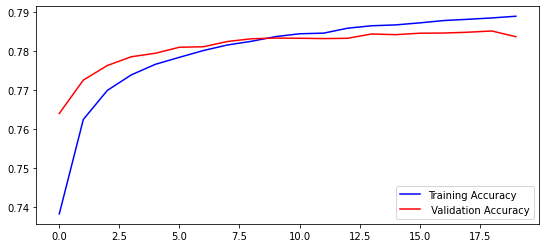

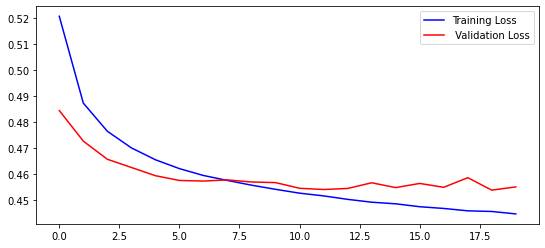

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.figure(figsize = (9,4))
plt.plot(acc, color = 'blue', label = 'Training Accuracy')
plt.plot(val_acc, color = 'red', label = ' Validation Accuracy')
plt.legend(loc='lower right')

plt.figure(figsize= (9,4))
plt.plot(loss,color = 'blue', label = 'Training Loss')
plt.plot(val_loss, color = 'red', label = ' Validation Loss')
plt.legend(loc='upper right')

In [33]:
def decode_sentiment(score):
    return 'Positive' if score > 0.5 else 'Negative'
        
scores = model.predict(x_test, verbose = 1, batch_size = 10000)
y_pred_D = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 2s 39ms/step


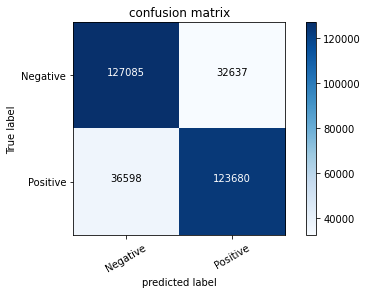

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap =cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation = 30)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
             horizontalalignment= 'center',
             color = "white" if cm[i,j]>thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

cnf_matrix = confusion_matrix(test_data.sentiment.tolist(), y_pred_D)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = test_data.sentiment.unique(), title = 'confusion matrix')
plt.show()

In [35]:
accuracy = max(acc)
print('Accuracy of model :', accuracy)

Accuracy of model : 0.7888851761817932


Precision, recall, and f1-score of the model

In [36]:
print(classification_report(list(test_data.sentiment), y_pred_D))

              precision    recall  f1-score   support

    Negative       0.78      0.80      0.79    159722
    Positive       0.79      0.77      0.78    160278

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [37]:
def final_sentiment(score):
    if score > 0.6:
            return 'Positive'
    elif (score > 0.4 and score < 0.6):
            return 'Neutral'
    else:
            return'Negative'
        
def pred(text):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_length) 
    score = model.predict([x_test])[0]
    label = final_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

**7. Test model on actual tweets**

Pull tweets from a certain user (Elon Musk).

In [38]:
posts = api.user_timeline(screen_name = "elonmusk", count = 10, lang = "en", tweet_mode="extended")

sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

print('--------Tweets: ')
print('\n')

for tweet in posts:
    print(tweet.full_text)
    prediction = pred(tweet.full_text)
    
    temp = prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
    
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   
avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg))
if avg > 0.6:
    print('The final grade is therefore positive.')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral.')
else:
    print('The final grade is therefore negative.')

--------Tweets: 


RT @SpaceX: All cargo is loaded, the hatch is closed, and Dragon is ready for an on-time departure from the @space_station at 5:05 p.m. ET.…
{'label': 'Neutral', 'score': 0.41865044832229614, 'elapsed_time': 0.4474060535430908}


@TrungTPhan That is dedication
{'label': 'Positive', 'score': 0.7703598737716675, 'elapsed_time': 0.04819512367248535}


More Twitter Files. 

Some conspiracies are actually true. https://t.co/0OgDkvWsq0
{'label': 'Neutral', 'score': 0.4391058683395386, 'elapsed_time': 0.04448342323303223}


@BillyM2k We will strive to increase the joy of Twitter!
{'label': 'Positive', 'score': 0.7537673711776733, 'elapsed_time': 0.045198917388916016}


@ggreenwald Tragic
{'label': 'Negative', 'score': 0.05653579905629158, 'elapsed_time': 0.04327988624572754}


RT @Tesla: Watch live TV &amp; stream your favorite shows in your Tesla when parked
{'label': 'Neutral', 'score': 0.5410040616989136, 'elapsed_time': 0.04762125015258789}


@paulg New UI coming this w

Pull tweets about a certain topic (sports).

In [39]:
search_term = '|'.join(['sport', 'player', 'game', 'ball'])

tweet_amount = 10
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

tweets = tweepy.Cursor(api.search_tweets, q = search_term, lang = 'en').items(tweet_amount)
print('--------Tweets: ')
print('\n')

for tweet in tweets:
    print(tweet.text)
    prediction = pred(tweet.text)
    
    temp = prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')  

avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg)) 

if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')

--------Tweets: 


@dj_mcghee09 @SupporterYelich @RefereeTwit @BrettKollmann I would add that the NFL is unique from a team sport wher… https://t.co/t4vOHMofmc
{'label': 'Positive', 'score': 0.6722877621650696, 'elapsed_time': 0.04783272743225098}


@ricknasty629 @NFL_DovKleiman is hillis a 24 yr old current sport ball player who had cardiac arrest mid game? just… https://t.co/rFVG89XUoC
{'label': 'Negative', 'score': 0.37397903203964233, 'elapsed_time': 0.04592728614807129}


RT @videolib_store: American Football
https://t.co/kfoH9NvSJj

#american #ball #defense #down #football #game #goalpost #gridiron #offense…
{'label': 'Positive', 'score': 0.692118763923645, 'elapsed_time': 0.043277740478515625}


American Football
https://t.co/kfoH9NvSJj

#american #ball #defense #down #football #game #goalpost #gridiron… https://t.co/2dGctlBHM0
{'label': 'Positive', 'score': 0.8459357023239136, 'elapsed_time': 0.043825626373291016}


Football Allstars (Soccer)
https://t.co/vk6bZPKXhg

#3d #ball 

In [40]:
search_term = '|'.join(['work', 'job', 'commute'])
tweet_amount = 10
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

tweets = tweepy.Cursor(api.search_tweets, q = search_term, lang = 'en').items(tweet_amount)
print('--------Tweets: ')
print('\n')

for tweet in tweets:
    print(tweet.text)
    prediction = pred(tweet.text)
    
    temp = prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   

avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg))

if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')

--------Tweets: 


Another thing I like about my job right now is that I don’t have to go out pag may bagyo or LPA to work. It was rea… https://t.co/1wp87uvAxH
{'label': 'Neutral', 'score': 0.4604584872722626, 'elapsed_time': 0.04690814018249512}


@maelstrom313 @esaagar Do you have kids? A job? Commute to work? Disposable income? 50+% of USians have zero in the… https://t.co/UQZak6AhQv
{'label': 'Negative', 'score': 0.36271166801452637, 'elapsed_time': 0.04274320602416992}


Missing Nashville, wonder if work will let me remote work from there 🤔 or can the @Titans give me a job, I'm good w… https://t.co/PZofZ76M39
{'label': 'Negative', 'score': 0.2550070881843567, 'elapsed_time': 0.04309225082397461}


@pvotro My daily commute is 16 miles, and sadly active transportation infrastructure is not advancing quickly. This… https://t.co/A5UCjqSzSu
{'label': 'Negative', 'score': 0.322311669588089, 'elapsed_time': 0.04293942451477051}


@matt_kercher when it rains it pours. Choose wisely!
1) Be

Pull tweets with certain queries (cars)

In [41]:
client = tweepy.Client(bearer_token = 'AAAAAAAAAAAAAAAAAAAAADvCkQEAAAAAqBldguiK%2FewFmwE1Cpd1UbQrlew%3D4Ysvdx21ITFfLHDHTL5nnV8q5KCNJ8dOLrYf23yIE8S3OOnCvw')
query = '#cars -is:retweet lang:en'
tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=10)
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

for tweet in tweets.data:
    print(tweet.text)
    prediction = pred(tweet.text)
    
    temp =prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   

avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg)) 

if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')

BMW is a luxury car brand known for its performance vehicles, as well as its iconic kidney-shaped grille. #Cars #BMW #jessicarmaniac
{'label': 'Positive', 'score': 0.7011932730674744, 'elapsed_time': 0.046305179595947266}


Before you decide to speed or do something while driving on the road, make sure to stay alert to these expensive traffic offences that could cost you. 

https://t.co/NDVmeI82zd 

#policystreet #cars #car #carinsurance #malaysia
{'label': 'Negative', 'score': 0.2802925705909729, 'elapsed_time': 0.0451197624206543}


IHRA is excited to announce that Interlake Dragway has renewed it's sanctioning agreement with us!

Thank you! Looking forward to future events at the track

Read the full article on our website
https://t.co/dQI2A7opVN

#ihramotorsports #dragracing #motorsports #cars #tracks https://t.co/nzhSJc0Mjf
{'label': 'Positive', 'score': 0.8719051480293274, 'elapsed_time': 0.04290938377380371}


Best Digital Marketing Strategy
#sales #marketing #business #sale #fa